# Ingredient Complexity & Recipe Ratings: A Predictive Analysis

**Name(s)**: Anna Doan, Jiya Makhija

**Website Link**: (https://jiya-makhija.github.io/recipes-and-ratings/)

In [2]:
# Importing required Libraries
import pandas as pd
import numpy as np
from pathlib import Path

import plotly.express as px
pd.options.plotting.backend = 'plotly'

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
#from dsc80_utils import * 

## Step 1: Introduction

##### With millions of recipes available online, identifying what makes a recipe successful can help both home cooks and platforms enhance their content. Understanding the factors that contribute to higher-rated recipes provides insights into user preferences, guiding both individuals in their cooking choices and recipe platforms in improving engagement. Specifically, we aim to answer the question: What factors contribute to a highly-rated recipe?
##### This project explores two datasets to examine the characteristics associated with highly-rated recipes:

- ##### **`RAW_recipes.csv`**: Contains **83,782 unique recipes**, each with attributes such as preparation time, ingredients, and nutritional information.
- ##### **`interactions.csv`**: Includes **731,927 user interactions**, capturing ratings and reviews.
##### Several key variables from these datasets are crucial for our analysis:
- ##### **Ingredients**: The `ingredients` column lists the components used in each recipe, while `n_ingredients` quantifies the total number of ingredients.
- ##### **Preparation Time**: The `minutes` column specifies the time required to prepare a dish, providing insight into the role of convenience in recipe popularity.
- ##### **User Ratings**: The `rating` column captures user evaluations of a recipe, serving as our primary measure of recipe success.
##### A key aspect of our analysis involves testing whether the number of ingredients in a recipe influences its rating. Specifically, we examine whether recipes with 9 or fewer ingredients receive different average ratings than those with more than 9 ingredients. Our hypothesis framework is as follows:

- ##### **Null Hypothesis**: The average rating of recipes with 9 or fewer ingredients is the same as that of recipes with more than 9 ingredients.

- ##### **Alternative Hypothesis** : The average rating of recipes with 9 or fewer ingredients is different from that of recipes with more than 9 ingredients.

##### By analyzing these factors, this project aims to identify trends in recipe ratings, offering insights into how the number of ingredients, preparation time, and other characteristics influence user preferences. Such findings could benefit both culinary content creators seeking to optimize recipe appeal and individuals searching for well-rated recipes that align with their needs and constraints.

## Step 2: Data Cleaning and Exploratory Data Analysis

In [3]:
# Loading datasets
recipes = pd.read_csv("/Applications/ucsd/dsc80-2025-wi/projects/project04/RAW_recipes.csv")
interactions = pd.read_csv("/Applications/ucsd/dsc80-2025-wi/projects/project04/interactions.csv")

In [4]:
# Cleaning Data
# Breaking down the 'nutrition' column into different nutritional components
recipes[["calories", "total_fat", "sugar", "sodium", "protein", "saturated_fat", "carbohydrates"]] = recipes["nutrition"].str.extract(r"\[(.*)\]").iloc[:, 0].str.split(",", expand=True)
recipes[["calories", "total_fat", "sugar", "sodium", "protein", "saturated_fat", "carbohydrates"]] = recipes[["calories", "total_fat", "sugar", "sodium", "protein", "saturated_fat", "carbohydrates"]].astype(float)
recipes.drop(columns=["nutrition"], inplace=True)

recipes.head()

,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,calories,total_fat,sugar,sodium,protein,saturated_fat,carbohydrates
0,1 brownies in the world best ever,333281,40,985201,2008-10-27,"['60-minutes-or-less', 'time-to-make', 'course...",10,['heat the oven to 350f and arrange the rack i...,"these are the most; chocolatey, moist, rich, d...","['bittersweet chocolate', 'unsalted butter', '...",9,138.4,10.0,50.0,3.0,3.0,19.0,6.0
1,1 in canada chocolate chip cookies,453467,45,1848091,2011-04-11,"['60-minutes-or-less', 'time-to-make', 'cuisin...",12,"['pre-heat oven the 350 degrees f', 'in a mixi...",this is the recipe that we use at my school ca...,"['white sugar', 'brown sugar', 'salt', 'margar...",11,595.1,46.0,211.0,22.0,13.0,51.0,26.0
2,412 broccoli casserole,306168,40,50969,2008-05-30,"['60-minutes-or-less', 'time-to-make', 'course...",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",9,194.8,20.0,6.0,32.0,22.0,36.0,3.0
3,millionaire pound cake,286009,120,461724,2008-02-12,"['time-to-make', 'course', 'cuisine', 'prepara...",7,"['freheat the oven to 300 degrees', 'grease a ...",why a millionaire pound cake? because it's su...,"['butter', 'sugar', 'eggs', 'all-purpose flour...",7,878.3,63.0,326.0,13.0,20.0,123.0,39.0
4,2000 meatloaf,475785,90,2202916,2012-03-06,"['time-to-make', 'course', 'main-ingredient', ...",17,"['pan fry bacon , and set aside on a paper tow...","ready, set, cook! special edition contest entr...","['meatloaf mixture', 'unsmoked bacon', 'goat c...",13,267.0,30.0,12.0,12.0,29.0,48.0,2.0


In [5]:
interactions.head()

,user_id,recipe_id,date,rating,review
0,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
1,126440,85009,2010-02-27,5,I made the Mexican topping and took it to bunk...
2,57222,85009,2011-10-01,5,"Made the cheddar bacon topping, adding a sprin..."
3,124416,120345,2011-08-06,0,"Just an observation, so I will not rate. I fo..."
4,2000192946,120345,2015-05-10,2,This recipe was OVERLY too sweet. I would sta...


In [6]:
# Merging these 2 datasets
merged_df = recipes.merge(interactions, left_on="id", right_on="recipe_id", how="left")

In [7]:
merged_df

,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,sugar,sodium,protein,saturated_fat,carbohydrates,user_id,recipe_id,date,rating,review
0,1 brownies in the world best ever,333281,40,985201,2008-10-27,"['60-minutes-or-less', 'time-to-make', 'course...",10,['heat the oven to 350f and arrange the rack i...,"these are the most; chocolatey, moist, rich, d...","['bittersweet chocolate', 'unsalted butter', '...",...,50.0,3.0,3.0,19.0,6.0,3.865850e+05,333281.0,2008-11-19,4.0,"These were pretty good, but took forever to ba..."
1,1 in canada chocolate chip cookies,453467,45,1848091,2011-04-11,"['60-minutes-or-less', 'time-to-make', 'cuisin...",12,"['pre-heat oven the 350 degrees f', 'in a mixi...",this is the recipe that we use at my school ca...,"['white sugar', 'brown sugar', 'salt', 'margar...",...,211.0,22.0,13.0,51.0,26.0,4.246800e+05,453467.0,2012-01-26,5.0,Originally I was gonna cut the recipe in half ...
2,412 broccoli casserole,306168,40,50969,2008-05-30,"['60-minutes-or-less', 'time-to-make', 'course...",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",...,6.0,32.0,22.0,36.0,3.0,2.978200e+04,306168.0,2008-12-31,5.0,This was one of the best broccoli casseroles t...
3,412 broccoli casserole,306168,40,50969,2008-05-30,"['60-minutes-or-less', 'time-to-make', 'course...",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",...,6.0,32.0,22.0,36.0,3.0,1.196280e+06,306168.0,2009-04-13,5.0,I made this for my son's first birthday party ...
4,412 broccoli casserole,306168,40,50969,2008-05-30,"['60-minutes-or-less', 'time-to-make', 'course...",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",...,6.0,32.0,22.0,36.0,3.0,7.688280e+05,306168.0,2013-08-02,5.0,Loved this. Be sure to completely thaw the br...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234424,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",...,2.0,3.0,6.0,5.0,0.0,8.445540e+05,308080.0,2009-10-14,5.0,These were very good. I meant to add some jala...
234425,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",...,57.0,11.0,7.0,21.0,9.0,8.042340e+05,298512.0,2008-05-02,1.0,I would rate this a zero if I could. I followe...
234426,cookies by design sugar shortbread cookies,298509,20,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...",5,"['whip sugar and shortening in a large bowl , ...","i've heard of the 'cookies by design' company,...","['granulated sugar', 'shortening', 'eggs', 'fl...",...,33.0,4.0,4.0,11.0,6.0,8.666510e+05,298509.0,2008-06-19,1.0,This recipe tastes nothing like the Cookies by...
234427,cookies by design sugar shortbread cookies,298509,20,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...",5,"['whip sugar and shortening in a large bowl , ...","i've heard of the 'cookies by design' company,...","['granulated sugar', 'shortening', 'eggs', 'fl...",...,33.0,4.0,4.0,11.0,6.0,1.546277e+06,298509.0,2010-02-08,5.0,"yummy cookies, i love this recipe me and my sm..."


In [8]:
merged_df['submitted'] = pd.to_datetime(merged_df['submitted'])
merged_df['date'] = pd.to_datetime(merged_df['date'])

In [9]:
merged_df["rating"] = merged_df["rating"].replace(0, np.nan)

In [10]:
merged_df

,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,sugar,sodium,protein,saturated_fat,carbohydrates,user_id,recipe_id,date,rating,review
0,1 brownies in the world best ever,333281,40,985201,2008-10-27,"['60-minutes-or-less', 'time-to-make', 'course...",10,['heat the oven to 350f and arrange the rack i...,"these are the most; chocolatey, moist, rich, d...","['bittersweet chocolate', 'unsalted butter', '...",...,50.0,3.0,3.0,19.0,6.0,3.865850e+05,333281.0,2008-11-19,4.0,"These were pretty good, but took forever to ba..."
1,1 in canada chocolate chip cookies,453467,45,1848091,2011-04-11,"['60-minutes-or-less', 'time-to-make', 'cuisin...",12,"['pre-heat oven the 350 degrees f', 'in a mixi...",this is the recipe that we use at my school ca...,"['white sugar', 'brown sugar', 'salt', 'margar...",...,211.0,22.0,13.0,51.0,26.0,4.246800e+05,453467.0,2012-01-26,5.0,Originally I was gonna cut the recipe in half ...
2,412 broccoli casserole,306168,40,50969,2008-05-30,"['60-minutes-or-less', 'time-to-make', 'course...",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",...,6.0,32.0,22.0,36.0,3.0,2.978200e+04,306168.0,2008-12-31,5.0,This was one of the best broccoli casseroles t...
3,412 broccoli casserole,306168,40,50969,2008-05-30,"['60-minutes-or-less', 'time-to-make', 'course...",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",...,6.0,32.0,22.0,36.0,3.0,1.196280e+06,306168.0,2009-04-13,5.0,I made this for my son's first birthday party ...
4,412 broccoli casserole,306168,40,50969,2008-05-30,"['60-minutes-or-less', 'time-to-make', 'course...",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",...,6.0,32.0,22.0,36.0,3.0,7.688280e+05,306168.0,2013-08-02,5.0,Loved this. Be sure to completely thaw the br...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234424,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",...,2.0,3.0,6.0,5.0,0.0,8.445540e+05,308080.0,2009-10-14,5.0,These were very good. I meant to add some jala...
234425,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",...,57.0,11.0,7.0,21.0,9.0,8.042340e+05,298512.0,2008-05-02,1.0,I would rate this a zero if I could. I followe...
234426,cookies by design sugar shortbread cookies,298509,20,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...",5,"['whip sugar and shortening in a large bowl , ...","i've heard of the 'cookies by design' company,...","['granulated sugar', 'shortening', 'eggs', 'fl...",...,33.0,4.0,4.0,11.0,6.0,8.666510e+05,298509.0,2008-06-19,1.0,This recipe tastes nothing like the Cookies by...
234427,cookies by design sugar shortbread cookies,298509,20,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...",5,"['whip sugar and shortening in a large bowl , ...","i've heard of the 'cookies by design' company,...","['granulated sugar', 'shortening', 'eggs', 'fl...",...,33.0,4.0,4.0,11.0,6.0,1.546277e+06,298509.0,2010-02-08,5.0,"yummy cookies, i love this recipe me and my sm..."


In [11]:
average_rating = merged_df.groupby("id")["rating"].mean()
merged_df = merged_df.merge(average_rating, on="id", how="left")
merged_df.rename(columns={"rating_x": "rating"}, inplace=True)
merged_df.rename(columns={"rating_y": "average_rating"}, inplace=True)

In [12]:
average_rating

id
275022    3.0
275024    3.0
275026    3.0
275030    5.0
275032    5.0
         ... 
537459    5.0
537485    5.0
537543    NaN
537671    NaN
537716    5.0
Name: rating, Length: 83782, dtype: float64

In [13]:
merged_df["ingredient_complexity"] = merged_df["n_ingredients"].apply(lambda x: "Simple" if x <= 9 else "Complex")

In [14]:
# Understanding our data
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234429 entries, 0 to 234428
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   name                   234428 non-null  object        
 1   id                     234429 non-null  int64         
 2   minutes                234429 non-null  int64         
 3   contributor_id         234429 non-null  int64         
 4   submitted              234429 non-null  datetime64[ns]
 5   tags                   234429 non-null  object        
 6   n_steps                234429 non-null  int64         
 7   steps                  234429 non-null  object        
 8   description            234315 non-null  object        
 9   ingredients            234429 non-null  object        
 10  n_ingredients          234429 non-null  int64         
 11  calories               234429 non-null  float64       
 12  total_fat              234429 non-null  floa

#### Univariate Analysis

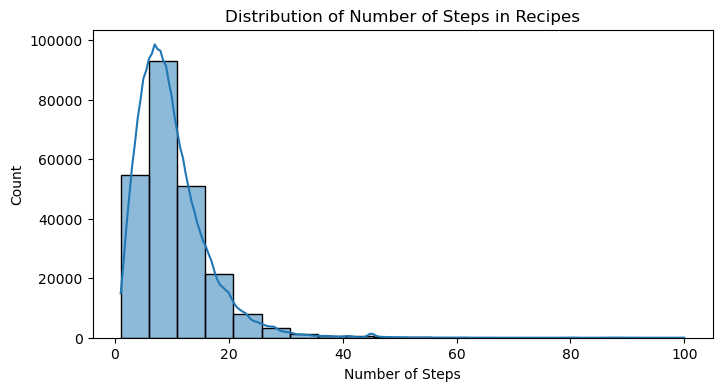

In [15]:
plt.figure(figsize=(8, 4))
sns.histplot(merged_df["n_steps"], bins=20, kde=True)
plt.title("Distribution of Number of Steps in Recipes")
plt.xlabel("Number of Steps")
plt.ylabel("Count")
plt.show()

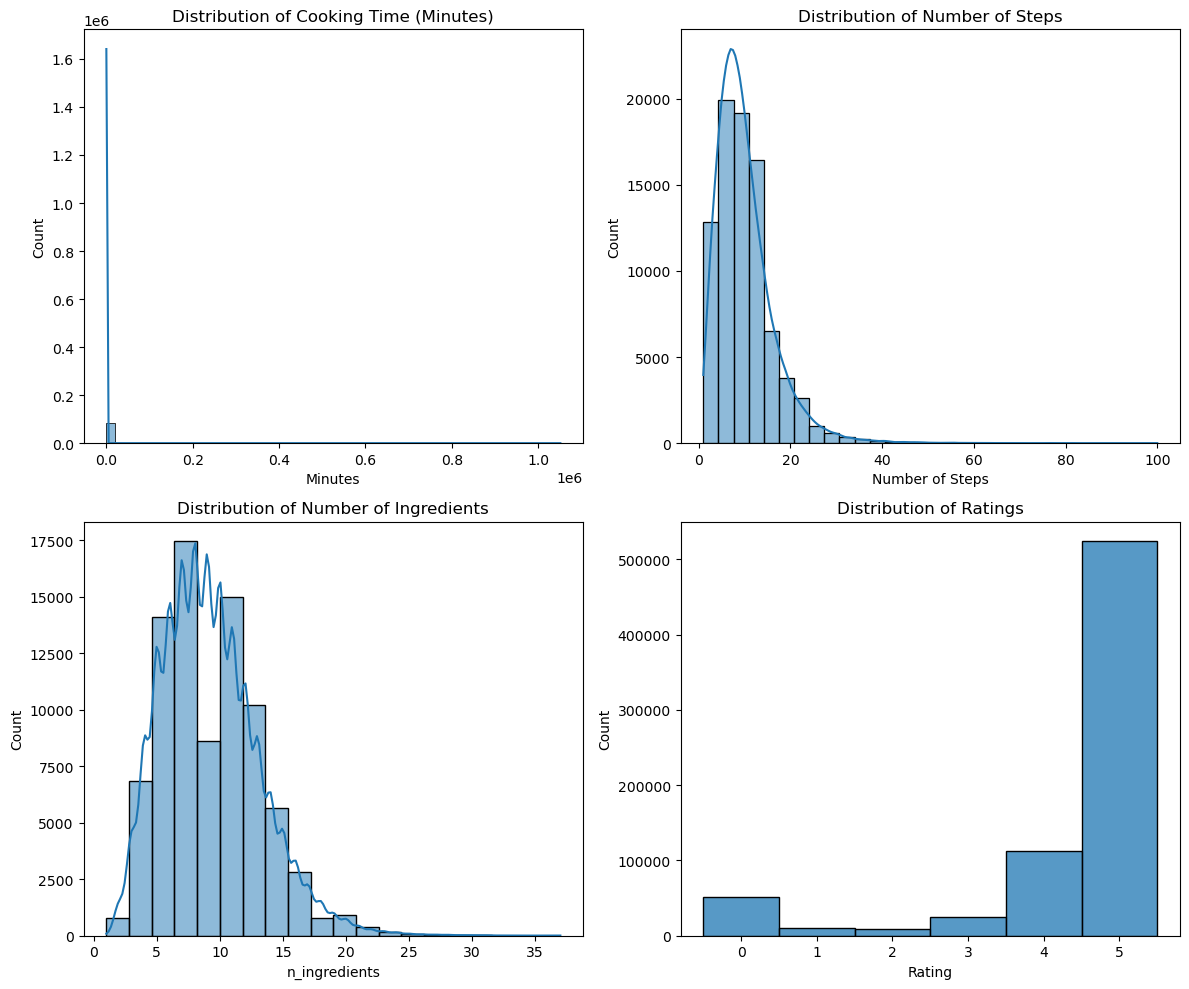

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Distribution of cooking time (minutes)
sns.histplot(recipes["minutes"], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title("Distribution of Cooking Time (Minutes)")
axes[0, 0].set_xlabel("Minutes")

# Distribution of number of steps
sns.histplot(recipes["n_steps"], bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Distribution of Number of Steps")
axes[0, 1].set_xlabel("Number of Steps")

# Distribution of number of ingredients
sns.histplot(recipes["n_ingredients"], bins=20, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Distribution of Number of Ingredients")

# Distribution of ratings
sns.histplot(interactions["rating"], bins=5, discrete=True, kde=False, ax=axes[1, 1])
axes[1, 1].set_title("Distribution of Ratings")
axes[1, 1].set_xlabel("Rating")

plt.tight_layout()
plt.show()

#### Bivariate Analysis

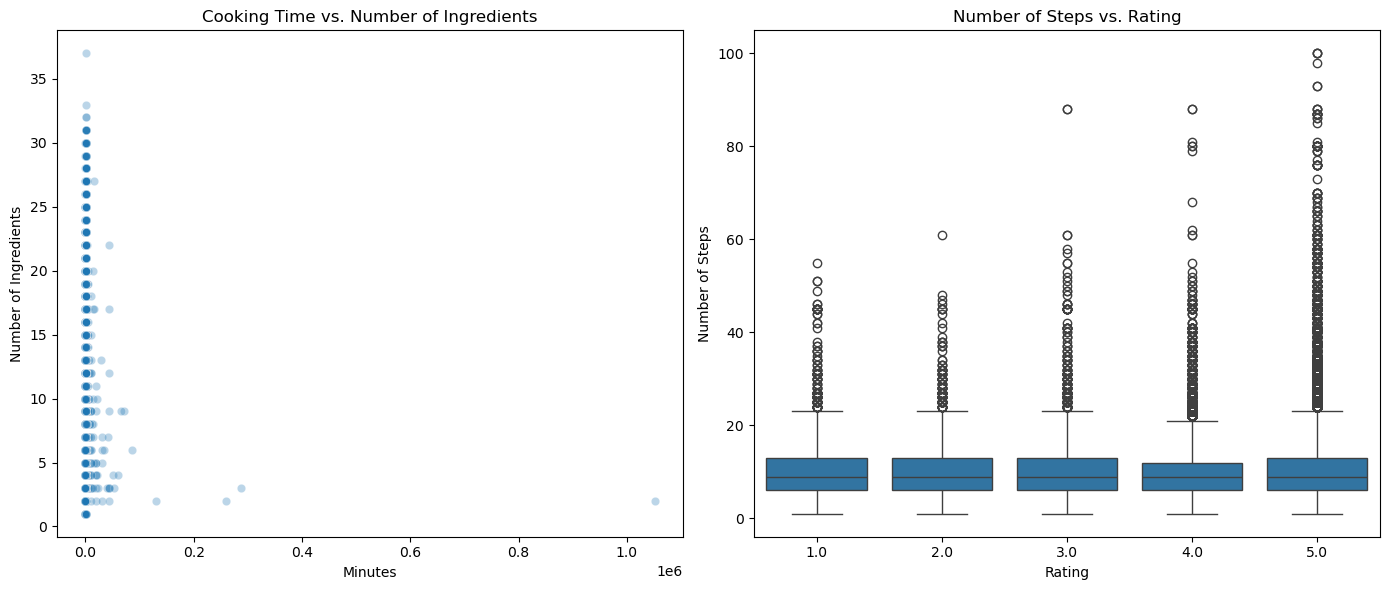

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot: Cooking time vs. Number of ingredients
sns.scatterplot(x=recipes["minutes"], y=recipes["n_ingredients"], alpha=0.3, ax=axes[0])
axes[0].set_title("Cooking Time vs. Number of Ingredients")
axes[0].set_xlabel("Minutes")
axes[0].set_ylabel("Number of Ingredients")

# Box plot: Number of steps vs. Rating
sns.boxplot(x=merged_df["rating"], y=merged_df["n_steps"], ax=axes[1])
axes[1].set_title("Number of Steps vs. Rating")
axes[1].set_xlabel("Rating")
axes[1].set_ylabel("Number of Steps")


plt.tight_layout()
plt.show()

In [18]:
custom_font = "Times New Roman"
title_font_size = 18
axis_font_size = 14
legend_font_size = 12

fig1 = go.Figure()
fig1.add_trace(go.Histogram(x=recipes["minutes"], nbinsx=50, marker_color="dodgerblue"))
fig1.update_layout(title="Distribution of Cooking Time (Minutes)",
                   xaxis_title="Minutes",
                   yaxis_title="Count",
                   font=dict(family=custom_font, size=axis_font_size),
                   title_font_size=title_font_size,
                   template="plotly_white",
                   annotations=[
                       dict(x=max(recipes["minutes"]), y=5, text="Longer cooking times are less frequent",
                            showarrow=True, arrowhead=2)
                   ])

fig2 = go.Figure()
fig2.add_trace(go.Histogram(x=recipes["n_steps"], nbinsx=30, marker_color="seagreen"))
fig2.update_layout(title="Distribution of Number of Steps",
                   xaxis_title="Number of Steps",
                   yaxis_title="Count",
                   font=dict(family=custom_font, size=axis_font_size),
                   title_font_size=title_font_size,
                   template="plotly_white")

fig3 = go.Figure()
fig3.add_trace(go.Histogram(x=recipes["n_ingredients"], nbinsx=20, marker_color="purple"))
fig3.update_layout(title="Distribution of Number of Ingredients",
                   xaxis_title="Number of Ingredients",
                   yaxis_title="Count",
                   font=dict(family=custom_font, size=axis_font_size),
                   title_font_size=title_font_size,
                   template="plotly_white")

fig4 = go.Figure()
fig4.add_trace(go.Histogram(x=interactions["rating"], nbinsx=5, marker_color="crimson"))
fig4.update_layout(title="Distribution of Ratings",
                   xaxis_title="Rating",
                   yaxis_title="Count",
                   font=dict(family=custom_font, size=axis_font_size),
                   title_font_size=title_font_size,
                   template="plotly_white")

fig5 = px.scatter(recipes, x="minutes", y="n_ingredients", color="n_ingredients",
                  color_continuous_scale="Viridis", title="Cooking Time vs. Number of Ingredients")
fig5.update_layout(xaxis_title="Minutes", yaxis_title="Number of Ingredients",
                   font=dict(family=custom_font, size=axis_font_size),
                   title_font_size=title_font_size, template="plotly_white")

fig6 = px.box(merged_df, x="rating", y="n_steps", color="rating",
              color_discrete_sequence=px.colors.qualitative.Bold, title="Number of Steps vs. Rating")
fig6.update_layout(xaxis_title="Rating", yaxis_title="Number of Steps",
                   font=dict(family=custom_font, size=axis_font_size),
                   title_font_size=title_font_size, template="plotly_white")


fig1.write_html("assets/distribution_cooking_time.html", include_plotlyjs='cdn')
fig2.write_html("assets/distribution_n_steps.html", include_plotlyjs='cdn')
fig3.write_html("assets/distribution_n_ingredients.html", include_plotlyjs='cdn')
fig4.write_html("assets/distribution_ratings.html", include_plotlyjs='cdn')
fig5.write_html("assets/cooking_time_vs_ingredients.html", include_plotlyjs='cdn')
fig6.write_html("assets/steps_vs_rating.html", include_plotlyjs='cdn')

html_files = {
    "distribution_cooking_time": "assets/distribution_cooking_time.html",
    "distribution_n_steps": "assets/distribution_n_steps.html",
    "distribution_n_ingredients": "assets/distribution_n_ingredients.html",
    "distribution_ratings": "assets/distribution_ratings.html",
    "cooking_time_vs_ingredients": "assets/cooking_time_vs_ingredients.html",
    "steps_vs_rating": "assets/steps_vs_rating.html",
}

#### Interesting Aggregates

In [19]:
# Grouping by ingredient complexity and calculating average rating
pivot_table = merged_df.groupby("ingredient_complexity")["average_rating"].agg(["count", "mean"]).reset_index()
pivot_table.columns = ["Ingredient Complexity", "Number of Recipes", "Average Rating"]

# for website
pivot_table_title = """
<html>
<head>
    <style>
        body {{ font-family: Arial, sans-serif; text-align: center; }}
        h2 {{ margin-bottom: 10px; }}
        table {{ margin-left: auto; margin-right: auto; border-collapse: collapse; width: 80%; }}
        th, td {{ border: 1px solid black; padding: 2px; text-align: center; }}
        th {{ background-color: #f2f2f2; }}
    </style>
</head>
<body>
    <h2>Average Rating by Ingredient Complexity</h2>
    {table}
</body>
</html>
"""


pivot_table_html = pivot_table_title.format(table=pivot_table.to_html(index=False, escape=False))

with open("assets/ingredient_complexity_pivot.html", "w") as f:
    f.write(pivot_table_html)

pivot_table

,Ingredient Complexity,Number of Recipes,Average Rating
0,Complex,94829,4.675235
1,Simple,136823,4.677428


In [20]:
# Average Cooking Time by Rating Category
pivot_table2 = merged_df.groupby("rating")["minutes"].agg(["count", "mean"]).reset_index()
pivot_table2.columns = ["Rating", "Number of Recipes", "Average Cooking Time (Minutes)"]

# for website
pivot_table2_title = """
<html>
<head>
    <style>
        body {{ font-family: Arial, sans-serif; text-align: center; }}
        h2 {{ margin-bottom: 10px; }}
        table {{ margin-left: auto; margin-right: auto; border-collapse: collapse; width: 80%; }}
        th, td {{ border: 1px solid black; padding: 2px; text-align: center; }}
        th {{ background-color: #f2f2f2; }}
    </style>
</head>
<body>
    <h2>Average Cooking Time by Rating Category</h2>
    {table}
</body>
</html>
"""


pivot_table2_html = pivot_table2_title.format(table=pivot_table2.to_html(index=False, escape=False))

with open("assets/time_rating_pivot.html", "w") as f:
    f.write(pivot_table2_html)

pivot_table2

,Rating,Number of Recipes,Average Cooking Time (Minutes)
0,1.0,2870,99.672474
1,2.0,2368,98.021537
2,3.0,7172,87.497630
3,4.0,37307,91.585038
4,5.0,169676,106.923878


## Step 3: Assessment of Missingness

In [21]:
merged_df['is_missing_rating'] = merged_df['rating'].isnull().astype(int)

In [22]:
merged_df.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients',
       'calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat',
       'carbohydrates', 'user_id', 'recipe_id', 'date', 'rating', 'review',
       'average_rating', 'ingredient_complexity', 'is_missing_rating'],
      dtype='object')

In [23]:
missing_values = merged_df.isnull().sum()

In [24]:
missing_data = missing_values[missing_values > 0].sort_values(ascending=False)
missing_data

rating            15036
average_rating     2777
description         114
review               58
name                  1
user_id               1
recipe_id             1
date                  1
dtype: int64

In [25]:
all_columns = merged_df.columns

In [26]:
all_columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients',
       'calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat',
       'carbohydrates', 'user_id', 'recipe_id', 'date', 'rating', 'review',
       'average_rating', 'ingredient_complexity', 'is_missing_rating'],
      dtype='object')

In [36]:
merged_df["missing_description"] = merged_df["description"].isna().astype(int)

def permutation_test(df, feature, n_permutations=1000):
    observed_diff = df.groupby("missing_description")[feature].mean().diff().iloc[-1]
    
    perm_diffs = []
    for _ in range(n_permutations):
        shuffled_missing = np.random.permutation(df["missing_description"])
        perm_diff = df.assign(shuffled_missing=shuffled_missing).groupby("shuffled_missing")[feature].mean().diff().iloc[-1]
        perm_diffs.append(perm_diff)
    

    p_value = np.mean(np.abs(perm_diffs) >= np.abs(observed_diff))
    
    fig = px.histogram(perm_diffs, nbins=30, histnorm="probability",
                       title=f"Permutation Test for Missing Description on {feature}",
                       labels={"value": f"Difference in {feature} Means"})
    fig.add_vline(x=observed_diff, line_color="red", annotation_text="Observed Difference")
    fig.show()
    
    return observed_diff, p_value, fig


obs_diff_rating, p_value_rating, fig_rating = permutation_test(merged_df, "rating")
obs_diff_n_steps, p_value_n_steps, fig_n_steps = permutation_test(merged_df, "n_steps")

print(f"Observed Difference in Rating: {obs_diff_rating}, p-value: {p_value_rating}")
print(f"Observed Difference in n_steps: {obs_diff_n_steps}, p-value: {p_value_n_steps}")

Observed Difference in Rating: -0.17518866252859944, p-value: 0.01
Observed Difference in n_steps: 0.7193570957673927, p-value: 0.246


In [37]:
fig_rating.write_html("assets/perm_rating.html", include_plotlyjs='cdn')
fig_n_steps.write_html("assets/perm_steps.html", include_plotlyjs='cdn')

##### Since p-value `n_steps` is higher than `0.05`, our test suggests that missing descriptions could be **MCAR** (Missing Completely at Random) on these columns.
##### Since p-values for columns like `rating` is lower than `0.05`, our test suggests that missing descriptions could be **MAR** (Missing at Random) on these columns.

## Step 4: Hypothesis Testing

##### **Null**: The average rating of recipes with 9 or fewer ingredients is the same as recipes with more than 9 ingredients. Any observed difference is due to random chance.\
##### **Alternative**: The average rating of recipes with 9 or fewer ingredients is different from recipes with more than 9 ingredients.


In [ ]:
merged_df.head()

,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,saturated_fat,carbohydrates,user_id,recipe_id,date,rating,review,average_rating,ingredient_complexity,is_missing_rating
0,1 brownies in the world best ever,333281,40,985201,2008-10-27,"['60-minutes-or-less', 'time-to-make', 'course...",10,['heat the oven to 350f and arrange the rack i...,"these are the most; chocolatey, moist, rich, d...","['bittersweet chocolate', 'unsalted butter', '...",...,19.0,6.0,3.865850e+05,333281.0,2008-11-19,4.0,"These were pretty good, but took forever to ba...",4.0,Simple,0
1,1 in canada chocolate chip cookies,453467,45,1848091,2011-04-11,"['60-minutes-or-less', 'time-to-make', 'cuisin...",12,"['pre-heat oven the 350 degrees f', 'in a mixi...",this is the recipe that we use at my school ca...,"['white sugar', 'brown sugar', 'salt', 'margar...",...,51.0,26.0,4.246800e+05,453467.0,2012-01-26,5.0,Originally I was gonna cut the recipe in half ...,5.0,Complex,0
2,412 broccoli casserole,306168,40,50969,2008-05-30,"['60-minutes-or-less', 'time-to-make', 'course...",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",...,36.0,3.0,2.978200e+04,306168.0,2008-12-31,5.0,This was one of the best broccoli casseroles t...,5.0,Simple,0
3,412 broccoli casserole,306168,40,50969,2008-05-30,"['60-minutes-or-less', 'time-to-make', 'course...",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",...,36.0,3.0,1.196280e+06,306168.0,2009-04-13,5.0,I made this for my son's first birthday party ...,5.0,Simple,0
4,412 broccoli casserole,306168,40,50969,2008-05-30,"['60-minutes-or-less', 'time-to-make', 'course...",6,"['preheat oven to 350 degrees', 'spray a 2 qua...",since there are already 411 recipes for brocco...,"['frozen broccoli cuts', 'cream of chicken sou...",...,36.0,3.0,7.688280e+05,306168.0,2013-08-02,5.0,Loved this. Be sure to completely thaw the br...,5.0,Simple,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234424,zydeco ya ya deviled eggs,308080,40,37779,2008-06-07,"['60-minutes-or-less', 'time-to-make', 'course...",7,"['in a bowl , combine the mashed yolks and may...","deviled eggs, cajun-style","['hard-cooked eggs', 'mayonnaise', 'dijon must...",...,5.0,0.0,8.445540e+05,308080.0,2009-10-14,5.0,These were very good. I meant to add some jala...,5.0,Simple,0
234425,cookies by design cookies on a stick,298512,29,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...",9,['place melted butter in a large mixing bowl a...,"i've heard of the 'cookies by design' company,...","['butter', 'eagle brand condensed milk', 'ligh...",...,21.0,9.0,8.042340e+05,298512.0,2008-05-02,1.0,I would rate this a zero if I could. I followe...,1.0,Complex,0
234426,cookies by design sugar shortbread cookies,298509,20,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...",5,"['whip sugar and shortening in a large bowl , ...","i've heard of the 'cookies by design' company,...","['granulated sugar', 'shortening', 'eggs', 'fl...",...,11.0,6.0,8.666510e+05,298509.0,2008-06-19,1.0,This recipe tastes nothing like the Cookies by...,3.0,Simple,0
234427,cookies by design sugar shortbread cookies,298509,20,506822,2008-04-15,"['30-minutes-or-less', 'time-to-make', 'course...",5,"['whip sugar and shortening in a large bowl , ...","i've heard of the 'cookies by design' company,...","['granulated sugar', 'shortening', 'eggs', 'fl...",...,11.0,6.0,1.546277e+06,298509.0,2010-02-08,5.0,"yummy cookies, i love this recipe me and my sm...",3.0,Simple,0


In [50]:
np.random.seed(42) 

In [119]:
import numpy as np

n_repetitions = 1000
differences = []

for i in range(n_repetitions):
    with_shuffled = merged_df.assign(Shuffled_Rating=np.random.permutation(merged_df["rating"]))
    
    group_means = (
        with_shuffled
        .groupby("ingredient_complexity")["Shuffled_Rating"]
        .mean()
    )

    difference = group_means.loc["Simple"] - group_means.loc["Complex"]
    differences.append(difference)

mean_ratings = merged_df.groupby("ingredient_complexity")["rating"].mean()
observed_difference = mean_ratings.loc["Simple"] - mean_ratings.loc["Complex"]

p_value = np.mean(np.abs(differences) >= np.abs(observed_difference))

print("Observed Difference in Mean Ratings:", observed_difference)
print("Permutation Test p-value:", p_value)

Observed Difference in Mean Ratings: 0.0036491500705029267
Permutation Test p-value: 0.227


Since **p = 0.227**, which is greater than 0.05, we fail to reject the null hypothesis. This suggests that there is not strong statistical evidence that the number of ingredients affects the ratings.

## Step 5: Framing a Prediction Problem

##### - We aim to predict the average rating of a recipe, treating this as a regression problem since ratings are continuous numerical values rather than distinct categories. Our goal is to build a model that can estimate a recipe’s rating based on its attributes, such as the number of ingredients, preparation time, nutritional content, user reviews.
##### - To evaluate our model, we will use **Root Mean Squared Error (RMSE)** as our primary metric. Since ratings are numerical and skewed toward higher values (4-5), RMSE provides a better measure of how well our predictions align with actual ratings, penalizing large errors more effectively than mean absolute error. This ensures that the model not only predicts close to the actual values but also minimizes significant deviations.

## Step 6: Baseline Model

In [38]:
merged_df[merged_df['rating'].isnull()]

,name,id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,saturated_fat,carbohydrates,user_id,recipe_id,date,rating,review,average_rating,ingredient_complexity,is_missing_rating
11,50 chili for the crockpot,501028,345,2628680,2013-05-28,"['course', 'main-ingredient', 'cuisine', 'prep...",4,['combine all ingredients in a 7-quart crockpo...,"first, thank you to *parsley* - chef # 199848 ...","['stewing beef', 'stewing pork', 'white onion'...",...,21.0,4.0,1.800120e+09,501028.0,2013-10-26,NaN,We tried it last weekend and it the entire fam...,5.00,Complex,1
16,lplermagronen,455351,55,1308592,2011-05-07,"['60-minutes-or-less', 'time-to-make', 'prepar...",15,['heat oven to 375f set a large pot of salted ...,"known as swiss mac n cheese, älplermagronen wa...","['potato', 'penne pasta', 'onions', 'butter', ...",...,63.0,33.0,1.255389e+07,455351.0,2014-10-17,NaN,"I made this using emmentaler, a swiss cheese. ...",NaN,Simple,1
20,der wiener schnitzel style chili dog sauce,523359,55,2000414501,2015-08-27,"['60-minutes-or-less', 'time-to-make', 'prepar...",16,['in a large size dutch oven or large size dee...,this was the best chili dog ever invented! i l...,"['ground beef', 'ground pork', 'water', 'corns...",...,28.0,4.0,1.142430e+05,523359.0,2015-09-05,NaN,This recipe is almost exactly like firemandave...,NaN,Complex,1
94,she crab cream of crab soup,275675,45,711025,2008-01-02,"['60-minutes-or-less', 'time-to-make', 'course...",3,"['combine all ingredients in double boiler', '...","i got this recipe from my grandmother, who was...","['cream of mushroom soup', 'cream of celery so...",...,69.0,12.0,7.181310e+05,275675.0,2008-01-13,NaN,Me and my wife made this recipe tonight. Somew...,4.75,Complex,1
95,she crab cream of crab soup,275675,45,711025,2008-01-02,"['60-minutes-or-less', 'time-to-make', 'course...",3,"['combine all ingredients in double boiler', '...","i got this recipe from my grandmother, who was...","['cream of mushroom soup', 'cream of celery so...",...,69.0,12.0,2.067470e+05,275675.0,2008-01-15,NaN,NO ONE from Maryland will appreciate this if y...,4.75,Complex,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234385,zuppa my weight watcher version of the olive g...,328409,70,690050,2008-10-01,"['time-to-make', 'course', 'preparation', 'occ...",7,"['in a big soup pot', 'cook ground turkey with...",this is the way that i have made a low fat ve...,"['ground turkey', 'black pepper', 'ground sage...",...,8.0,15.0,2.618489e+06,328409.0,2013-01-06,NaN,this recipe is terrible!<br/>For one the last ...,5.00,Complex,1
234389,zuppa toscana from olive garden,388574,60,634137,2009-09-03,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['remove sausage from casings if applicable', ...",this is my favorite soup. this recipe is suppo...,"['mild italian sausage', 'crushed red pepper f...",...,87.0,9.0,1.480020e+05,388574.0,2012-10-06,NaN,Family favorite! Kids request this on cold win...,4.50,Complex,1
234405,zwiebelwhe swiss onion tart,410985,165,993604,2010-01-30,"['weeknight', 'time-to-make', 'course', 'main-...",38,"['crust:', 'pulse flour , baking powder , and ...",a delicious bacon-studded tart.,"['flour', 'baking powder', 'kosher salt', 'uns...",...,90.0,9.0,1.437197e+06,410985.0,2010-01-31,NaN,????how many onions?,5.00,Complex,1
234407,zwiebelwhe swiss onion tart,410985,165,993604,2010-01-30,"['weeknight', 'time-to-make', 'course', 'main-...",38,"['crust:', 'pulse flour , baking powder , and ...",a delicious bacon-studded tart.,"['flour', 'baking powder', 'kosher salt', 'uns...",...,90.0,9.0,2.001558e+09,410985.0,2017-05-28,NaN,It's really Swiss onion tart?,5.00,Complex,1


In [40]:
df = merged_df.copy()

rating_means = df.groupby(["ingredient_complexity", "n_ingredients"])["rating"].mean().to_dict()

df["rating"] = df.apply(lambda row: rating_means.get((row["ingredient_complexity"], row["n_ingredients"]), np.nan) 
                        if pd.isna(row["rating"]) else row["rating"], axis=1)

print(df["rating"].isna().sum())

0


In [41]:
merged_df.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients',
       'calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat',
       'carbohydrates', 'user_id', 'recipe_id', 'date', 'rating', 'review',
       'average_rating', 'ingredient_complexity', 'is_missing_rating'],
      dtype='object')

In [42]:
df["rating"] = df["rating"].astype(int)

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

features = ["minutes", "n_steps", "n_ingredients"]
target = "rating"

linear_model_df = merged_df.dropna(subset=features + [target])

X = linear_model_df[features]
y = linear_model_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

baseline_pipeline = Pipeline([
    ("scaler", StandardScaler()), 
    ("model", LinearRegression()) 
])

baseline_pipeline.fit(X_train, y_train)

y_pred = baseline_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
rmse

np.float64(0.7138650256126987)

##### Our baseline model achieved an RMSE of **0.713**, meaning that, on average, our predicted recipe ratings deviate by about **0.713 points** from the actual ratings.

## Step 7: Final Model

In [ ]:
# Feature engineering new columns
merged_df['time_per_step'] = merged_df['minutes'] / (merged_df['n_steps'] + 1)
merged_df['ingredients_per_step'] = merged_df['n_ingredients'] / (merged_df['n_steps'] + 1)

In [46]:
merged_df.columns

Index(['name', 'id', 'minutes', 'contributor_id', 'submitted', 'tags',
       'n_steps', 'steps', 'description', 'ingredients', 'n_ingredients',
       'calories', 'total_fat', 'sugar', 'sodium', 'protein', 'saturated_fat',
       'carbohydrates', 'user_id', 'recipe_id', 'date', 'rating', 'review',
       'average_rating', 'ingredient_complexity', 'is_missing_rating',
       'time_per_step', 'ingredients_per_step'],
      dtype='object')

##### `Attempt 1`

In [ ]:
# Trying linear regression with new features
features = ["minutes", "time_per_step", "ingredients_per_step","calories"]
target = "rating"

linear_model_df2 = merged_df.dropna(subset=features + [target])

X = linear_model_df2[features]
y = linear_model_df2[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

baseline_pipeline = Pipeline([
    ("scaler", StandardScaler()), 
    ("model", LinearRegression()) 
])

baseline_pipeline.fit(X_train, y_train)

y_pred = baseline_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
rmse

np.float64(0.713825273763129)

##### `Attempt 2`


In [75]:
# Trying to predict a different target variable "n_steps" since we were not able to get a better RMSE score predicting ratins than the baseline model.

from sklearn.metrics import mean_squared_error, r2_score

cat_feature = "ingredient_complexity"  
numeric_features = ["minutes", "calories", "n_ingredients", "protein", "saturated_fat", "carbohydrates"]
merged_df = merged_df.dropna(subset=numeric_features + [cat_feature])

target = "n_steps"

all_features = [cat_feature] + numeric_features

merged_df = merged_df.dropna(subset=all_features + [target])

X = merged_df[all_features]
y = merged_df[target].astype(float)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(), [cat_feature]),
    ("num", StandardScaler(), numeric_features)
], sparse_threshold=0) 

pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(random_state=42))
])

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Test MSE:", mse)
print("Test R2:", r2)

Test MSE: 7.673063597249407
Test R2: 0.8100569525001502


In [76]:
mse**0.5

np.float64(2.770029530032019)

##### This means our model’s predictions for the number of steps deviate by about 2.77 steps on average from the actual values.

##### `Attempt 3`


In [ ]:
# Attempt at a final model but with only review as a new column from the baseline model
df = merged_df.copy()
df = df.dropna(subset=["minutes", "n_steps", "n_ingredients", "calories", "protein", "saturated_fat", "carbohydrates", "rating", "review"])

features_final = ["n_steps", "ingredient_complexity", "review"]
target = "rating"

X_train, X_test, y_train, y_test = train_test_split(df[features_final], df[target], test_size=0.2, random_state=42)

numerical_features = ["n_steps"]
categorical_features = ["ingredient_complexity"]
text_features = "review"

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(drop="first"), categorical_features),
    ("text", Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english", max_features=200))
    ]), text_features)
])

param_grid = {
    "model__n_estimators": [20, 30,40],  
    "model__max_depth": [10, 20, None]
}

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)


mse_final = mean_squared_error(y_test, y_pred)
rmse_final = mse_final ** 0.5
print("Final Model RMSE:", rmse_final)
print("Best Hyperparameters:", grid_search.best_params_)

Final Model RMSE: 0.6343251068403761
Best Hyperparameters: {'model__max_depth': None, 'model__n_estimators': 40}


### `Final Model`

In [55]:

rf_reg_df2 = merged_df.copy()
rf_reg_df2 = rf_reg_df2.dropna(subset=["time_per_step", "ingredients_per_step", "minutes", "n_steps", "n_ingredients", "calories", "protein", "saturated_fat", "carbohydrates", "rating", "review"])

rf_reg_df2["nutrition_density"] = (rf_reg_df2["calories"] + rf_reg_df2["protein"] + rf_reg_df2["saturated_fat"] + rf_reg_df2["carbohydrates"]) / (rf_reg_df2["calories"] + 1)

features_final = ["n_steps", "minutes", "n_ingredients", "review", "ingredients_per_step","time_per_step","nutrition_density"]
target = "rating"


X_train, X_test, y_train, y_test = train_test_split(rf_reg_df2[features_final], rf_reg_df2[target], test_size=0.2, random_state=42)

numerical_features = ["n_steps", "minutes", "n_ingredients", "ingredients_per_step", "time_per_step", "nutrition_density"]
text_features = "review"

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("text", Pipeline([
        ("tfidf", TfidfVectorizer(stop_words="english", max_features=100))
    ]), text_features)
])

param_grid = {
    "model__n_estimators": [40, 50],  
    "model__max_depth": [5, None]
}

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring="r2", n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)


mse_final = mean_squared_error(y_test, y_pred)
rmse_final = mse_final ** 0.5
print("Final Model RMSE:", rmse_final)
print("Best Hyperparameters:", grid_search.best_params_)

Final Model RMSE: 0.6513883452558045
Best Hyperparameters: {'model__max_depth': None, 'model__n_estimators': 50}


#

##### Our final model achieved an **RMSE of 0.651**, which represents an improvement over the baseline **RMSE of 0.71**.
##### The best hyperparameters selected through **GridSearchCV** were:
- ##### **Max Depth:** None
- ##### **Number of Estimators:** 50


## Step 8: Fairness Analysis

##### **Null Hypothesis**: The model is fair. The RMSE for simple recipes and complex recipes are similar, and any differences are due to random chance.
##### **Alternative Hypothesis**: The model is unfair. The RMSE is significantly different between simple and complex recipes, indicating the model performs better for one group than the other.

In [ ]:
results = X_test
results.head()

In [82]:
results["ingredient_complexity"] = results["n_steps"].apply(lambda x: "Simple" if x <= 9 else "Complex")

In [98]:
def compute_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

rmse_simple = compute_rmse(y_test[results["ingredient_complexity"] == "Simple"], 
                           y_pred[results["ingredient_complexity"] == "Simple"])

rmse_complex = compute_rmse(y_test[results["ingredient_complexity"] == "Complex"], 
                            y_pred[results["ingredient_complexity"] == "Complex"])

observed_difference = abs(rmse_simple - rmse_complex)

print("RMSE for Simple Recipes:", rmse_simple)
print("RMSE for Complex Recipes:", rmse_complex)
print("Observed RMSE Difference:", observed_difference)

RMSE for Simple Recipes: 0.6416025085449809
RMSE for Complex Recipes: 0.663743712106286
Observed RMSE Difference: -0.02214120356130511


##### We got very close values for Simple (0.6416) and Complex (0.6637), an observed difference of 0.0221, but to determine the statistical significance of this difference, we run a permutation test.

In [ ]:
n_permutations = 1000
rmse_differences = []

for _ in range(n_permutations):
    shuffled_complexity = np.random.permutation(results["ingredient_complexity"])

    rmse_simple_shuffled = compute_rmse(y_test[shuffled_complexity == "Simple"], y_pred[shuffled_complexity == "Simple"])
    rmse_complex_shuffled = compute_rmse(y_test[shuffled_complexity == "Complex"], y_pred[shuffled_complexity == "Complex"])

    rmse_differences.append(abs(rmse_simple_shuffled - rmse_complex_shuffled))

p_value = np.mean(np.array(rmse_differences) >= observed_difference)

print("Permutation Test p-value:", p_value)

In [97]:
rmse_diff_series = pd.Series(rmse_differences)

fig = px.histogram(rmse_diff_series,  nbins=29,  histnorm='probability', title="Difference in RMSE (Simple - Complex)", color_discrete_sequence=['darkblue'])

fig.add_vline(x=observed_difference, line_color='red')
fig.update_layout(xaxis_range=[-0.01, 0.05])

fig.show()

##### Since our `p-value (0.023)` is below the common threshold of 0.05, we reject the null hypothesis. This suggests that our model is **not fair**, it appears to predict ratings slightly better for one group over the other. \
##### And our `RMSE (Simple - Complex) = -0.0221`, this means that the RMSE for Complex recipes is higher, indicating that the model performs worse on Complex recipes and better on Simple recipes.